# Titanic Dataset Analysis
### Mehmet Emin Titrek - 2018300231

## Importing necessary libraries

In [1]:
library(data.table)
library(dplyr)
library(ggplot2)
library(caret)
library(ROCR)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: lattice

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


## Importing dataset and cleaning

In [2]:
data_url <- "https://raw.githubusercontent.com/MeminT99/ad455/main/assignment-8/titanic.csv"
raw_data <- fread(data_url)
head(raw_data)

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>,<chr>,<chr>
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,,Q


In [3]:
str(raw_data)

Classes ‘data.table’ and 'data.frame':	891 obs. of  12 variables:
 $ PassengerId: int  1 2 3 4 5 6 7 8 9 10 ...
 $ Survived   : int  0 1 1 1 0 0 0 0 1 1 ...
 $ Pclass     : int  3 1 3 1 3 3 1 3 3 2 ...
 $ Name       : chr  "Braund, Mr. Owen Harris" "Cumings, Mrs. John Bradley (Florence Briggs Thayer)" "Heikkinen, Miss. Laina" "Futrelle, Mrs. Jacques Heath (Lily May Peel)" ...
 $ Sex        : chr  "male" "female" "female" "female" ...
 $ Age        : num  22 38 26 35 35 NA 54 2 27 14 ...
 $ SibSp      : int  1 1 0 1 0 0 0 3 0 1 ...
 $ Parch      : int  0 0 0 0 0 0 0 1 2 0 ...
 $ Ticket     : chr  "A/5 21171" "PC 17599" "STON/O2. 3101282" "113803" ...
 $ Fare       : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Cabin      : chr  "" "C85" "" "C123" ...
 $ Embarked   : chr  "S" "C" "S" "S" ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [4]:
missing_raw <- raw_data %>%
  summarise_all(~ sum(is.na(.) | . == ""))

missing_raw

PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,177,0,0,0,0,687,2


In [5]:
## Apply function to calculate number of unique elements in each column
sapply(raw_data, function(x) length(unique(x)))

PassengerId    Survived      Pclass        Name         Sex         Age 
        891           2           3         891           2          89 
      SibSp       Parch      Ticket        Fare       Cabin    Embarked 
          7           7         681         248         148           4

In [6]:
DT <- raw_data %>%
  select(-PassengerId, -Name, -Ticket, -Cabin) %>%
  filter(!is.na(Age)) %>%
  mutate(is_female = factor(ifelse(Sex == "female", 1, 0))) %>%
  select(-Sex) %>%
  mutate(Embarked = factor(ifelse(is.na(Embarked) | Embarked == "", names(table(raw_data$Embarked)[which.max(table(raw_data$Embarked))]), Embarked))) %>%
  mutate(Survived = factor(Survived),
         Pclass = factor(Pclass))

- Removing irrelevant columns
- Filtering out rows with missing age information
- Creating a binary indicator for female passengers
- Handling missing values 
- Converting categorical columns into factor variables

In [7]:
head(DT)

Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,is_female
<fct>,<fct>,<dbl>,<int>,<int>,<dbl>,<fct>,<fct>
0,3,22,1,0,7.2500,S,0
1,1,38,1,0,71.2833,C,1
1,3,26,0,0,7.9250,S,1
1,1,35,1,0,53.1000,S,1
0,3,35,0,0,8.0500,S,0
0,1,54,0,0,51.8625,S,0


In [8]:
str(DT)

Classes ‘data.table’ and 'data.frame':	714 obs. of  8 variables:
 $ Survived : Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 2 2 2 ...
 $ Pclass   : Factor w/ 3 levels "1","2","3": 3 1 3 1 3 1 3 3 2 3 ...
 $ Age      : num  22 38 26 35 35 54 2 27 14 4 ...
 $ SibSp    : int  1 1 0 1 0 0 3 0 1 1 ...
 $ Parch    : int  0 0 0 0 0 0 1 2 0 1 ...
 $ Fare     : num  7.25 71.28 7.92 53.1 8.05 ...
 $ Embarked : Factor w/ 3 levels "C","Q","S": 3 1 3 3 3 3 3 3 1 3 ...
 $ is_female: Factor w/ 2 levels "0","1": 1 2 2 2 1 1 1 2 2 2 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [9]:
missing_DT <- DT %>%
  summarise_all(~ sum(is.na(.) | . == ""))

missing_DT 

Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,is_female
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0


## Descriptive analysis

In [10]:
summary(DT)

 Survived Pclass       Age            SibSp            Parch       
 0:424    1:186   Min.   : 0.42   Min.   :0.0000   Min.   :0.0000  
 1:290    2:173   1st Qu.:20.12   1st Qu.:0.0000   1st Qu.:0.0000  
          3:355   Median :28.00   Median :0.0000   Median :0.0000  
                  Mean   :29.70   Mean   :0.5126   Mean   :0.4314  
                  3rd Qu.:38.00   3rd Qu.:1.0000   3rd Qu.:1.0000  
                  Max.   :80.00   Max.   :5.0000   Max.   :6.0000  
      Fare        Embarked is_female
 Min.   :  0.00   C:130    0:453    
 1st Qu.:  8.05   Q: 28    1:261    
 Median : 15.74   S:556             
 Mean   : 34.69                     
 3rd Qu.: 33.38                     
 Max.   :512.33                     

### Survived - Gender

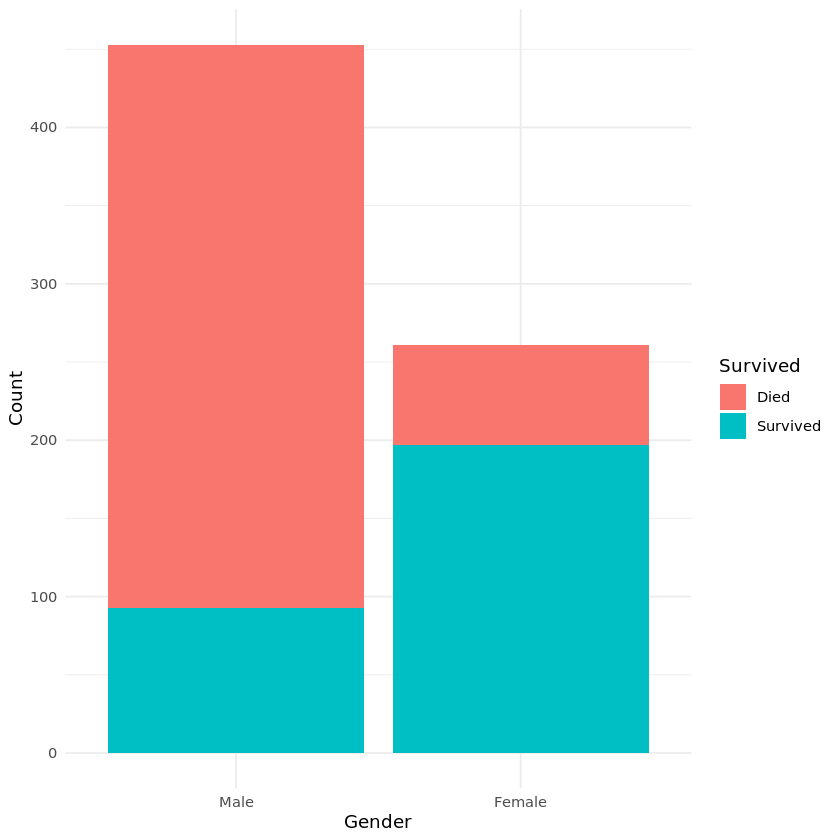

In [11]:
ggplot(DT, aes(x = is_female, fill = Survived))+
  geom_bar()+
  labs(x = "Gender", y = "Count", fill = "Survived")+
  scale_x_discrete(labels = c('0'="Male", '1'="Female"))+
  scale_fill_discrete(labels=c('Died', 'Survived'))+
  theme_minimal()

### Survived - Embarked

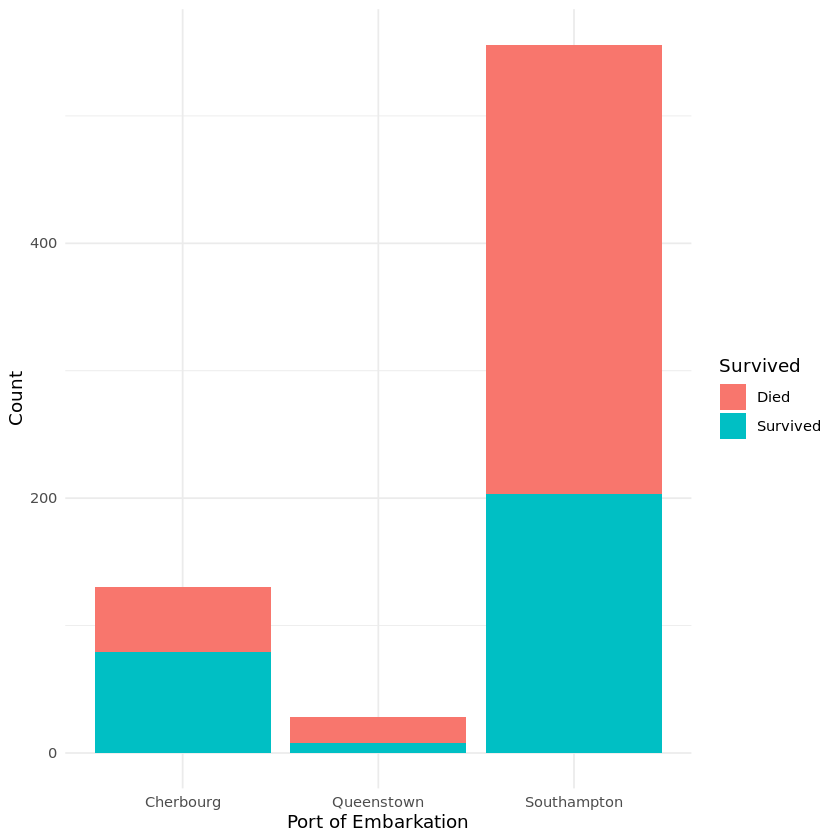

In [12]:
ggplot(DT, aes(x = Embarked, fill = Survived)) +
  geom_bar() +
  labs(x = "Port of Embarkation", y = "Count", fill = "Survived") +
  scale_x_discrete(labels = c("C" = "Cherbourg", "Q" = "Queenstown", "S" = "Southampton")) +
  scale_fill_discrete(labels = c("Died", "Survived")) +
  theme_minimal()

### Survived - Pclass

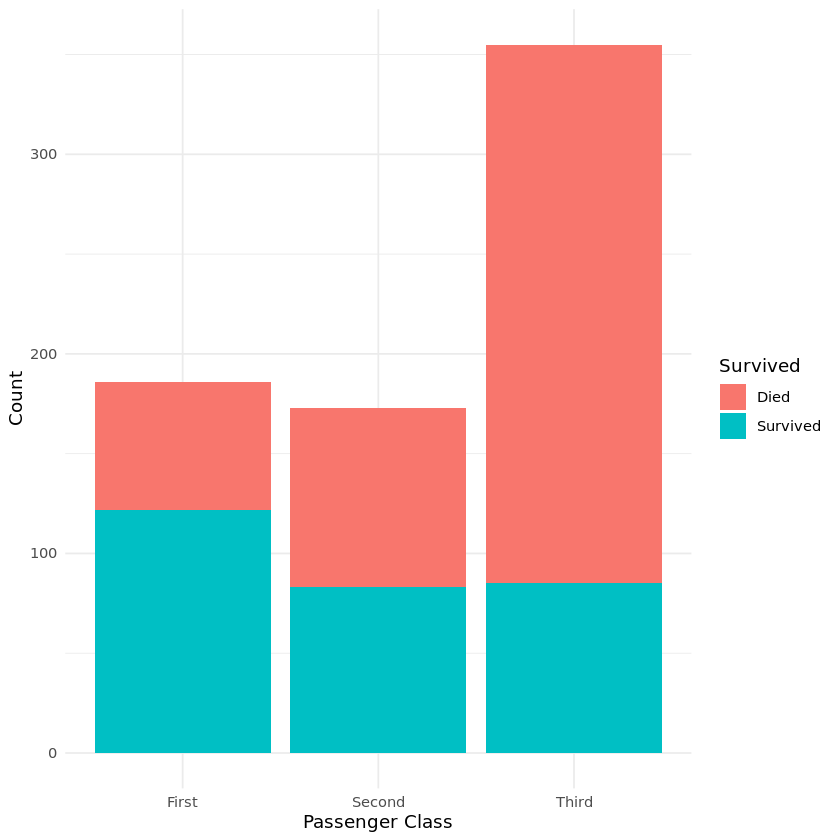

In [13]:
ggplot(DT, aes(x = Pclass, fill = Survived)) +
  geom_bar() +
  labs(x = "Passenger Class", y = "Count", fill = "Survived") +
  scale_x_discrete(labels = c("1" = "First", "2" = "Second", "3" = "Third")) +
  scale_fill_discrete(labels = c("Died", "Survived")) +
  theme_minimal()

### Survived - Age

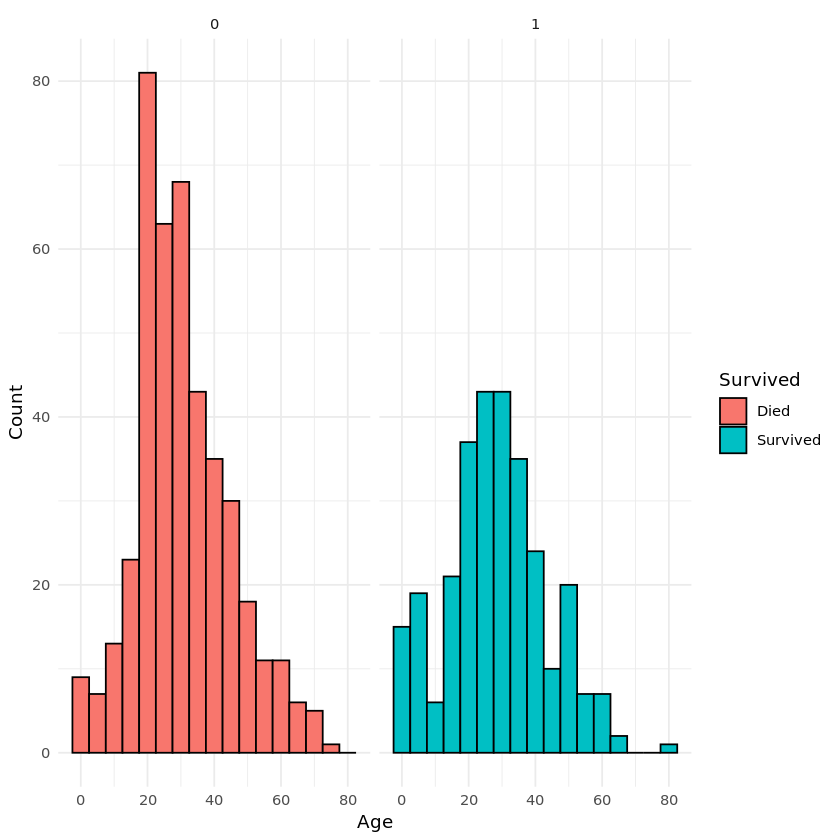

In [14]:
ggplot(DT, aes(x = Age, fill = Survived))+
  geom_histogram(binwidth = 5, color = "black")+
  labs(x = "Age", y = "Count")+
  facet_grid(.~Survived)+
  scale_fill_discrete(labels = c("Died", "Survived")) +
  theme_minimal()

### Survived - SibSp

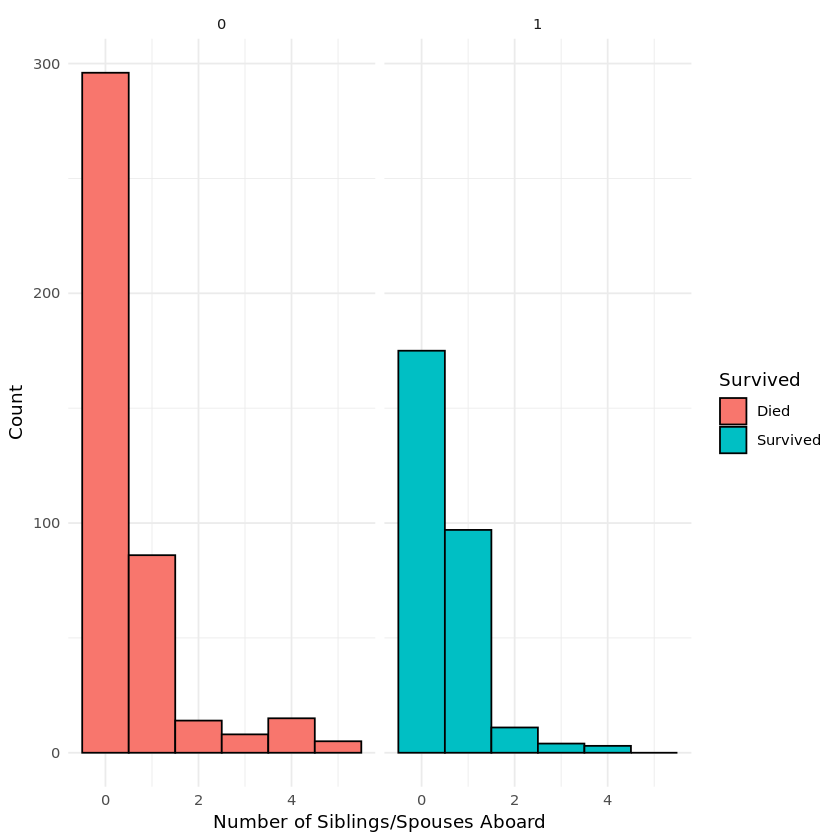

In [15]:
ggplot(DT, aes(x = SibSp, fill = Survived)) +
  geom_histogram(binwidth = 1, color = "black") +
  labs(x = "Number of Siblings/Spouses Aboard", y = "Count") +
  facet_grid(.~Survived) +
  scale_fill_discrete(labels = c("Died", "Survived")) +
  theme_minimal()

### Survived - Parch

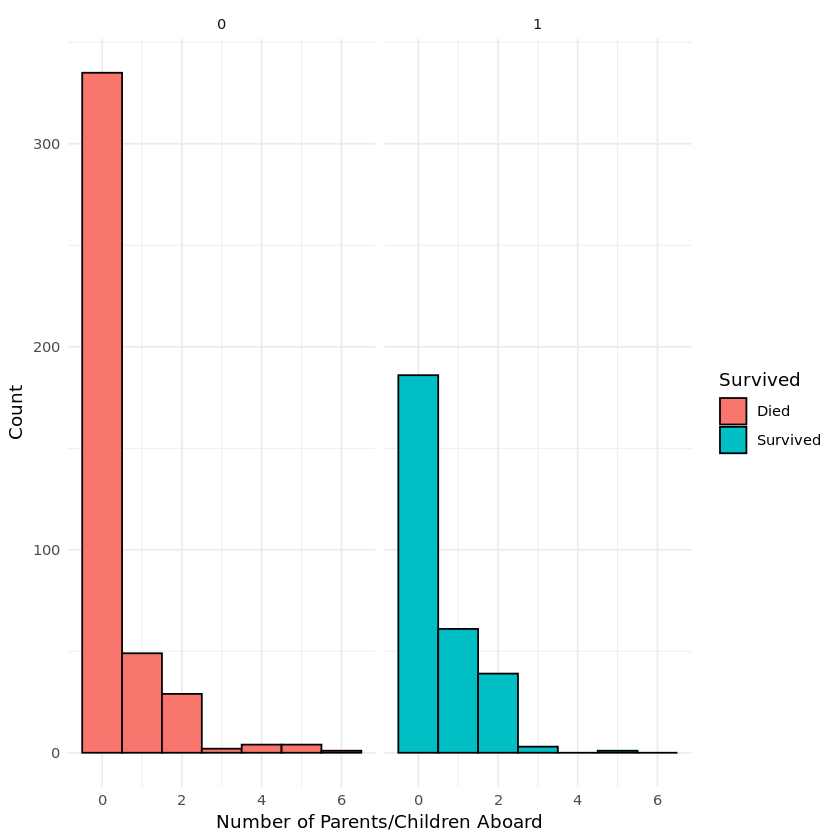

In [16]:
ggplot(DT, aes(x = Parch, fill = Survived)) +
  geom_histogram(binwidth = 1, color = "black") +
  labs(x = "Number of Parents/Children Aboard", y = "Count") +
  facet_grid(.~Survived) +
  scale_fill_discrete(labels = c("Died", "Survived")) +
  theme_minimal()

### Survived - Fare

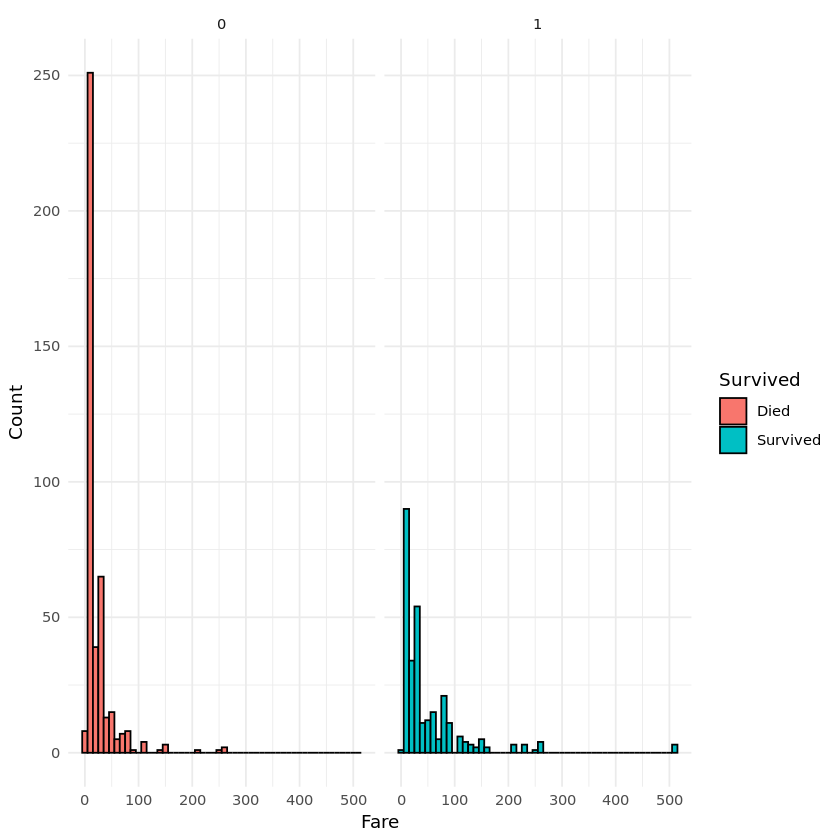

In [17]:
ggplot(DT, aes(x = Fare, fill = Survived))+
  geom_histogram(binwidth = 10, color = "black")+
  labs(x = "Fare", y = "Count")+
  facet_grid(.~Survived)+
  scale_fill_discrete(labels = c("Died", "Survived")) +
  theme_minimal()

### Correlation Matrix

In [18]:
DT_numeric <- DT[, lapply(.SD, as.numeric)]

# Exclude factor variables from the correlation calculation
numeric_vars <- DT_numeric[, sapply(.SD, is.numeric)]
cor_matrix <- round(cor(DT_numeric[, numeric_vars, with = FALSE]), digits=2)

cor_matrix

,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,is_female
Survived,1.00,-0.36,-0.08,-0.02,0.09,0.27,-0.18,0.54
Pclass,-0.36,1.00,-0.37,0.07,0.03,-0.55,0.24,-0.16
Age,-0.08,-0.37,1.00,-0.31,-0.19,0.10,-0.03,-0.09
SibSp,-0.02,0.07,-0.31,1.00,0.38,0.14,0.03,0.10
Parch,0.09,0.03,-0.19,0.38,1.00,0.21,0.01,0.25
Fare,0.27,-0.55,0.10,0.14,0.21,1.00,-0.28,0.18
Embarked,-0.18,0.24,-0.03,0.03,0.01,-0.28,1.00,-0.11
is_female,0.54,-0.16,-0.09,0.10,0.25,0.18,-0.11,1.00


## Logistic Regression Model

- **Target Variable (`Survived`)**:
   - This is the variable we are trying to predict. In logistic regression, it is a binary variable representing survival status (0 for not survived, 1 for survived).

- **Features**:
   - **`is_female`**: We include this variable because from our exploration, we observed a strong correlation between being female and survival. Female passengers were more likely to survive.
   - **`Pclass`**: Passenger class is also included because there was a correlation between passenger class and survival. Higher-class passengers were more likely to survive.
   - **`Embarked`**: Port of embarkation could also be a factor in survival, although the correlation was not as strong as other variables. Nevertheless, it might provide some predictive power.
   - **`Fare`**: Fare is included as it might be related to passenger class and thus to survival. Passengers who paid higher fares might be more likely to survive.

In [19]:
set.seed(455)
train_indices <- sample(nrow(DT), 0.7 * nrow(DT))

train_data <- DT[train_indices, c("is_female", "Pclass", "Embarked", "Fare", "Survived")]
test_data <- DT[-train_indices, c("is_female", "Pclass", "Embarked", "Fare", "Survived")]

In [20]:
logistic_model <- glm(Survived ~ is_female + Pclass + Embarked + Fare,
                      data = train_data,
                      family = binomial)

In [21]:
summary(logistic_model)$deviance.resid %>% summary()

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-2.44549 -0.70500 -0.44334 -0.03031  0.68257  2.19408 

In [22]:
summary(logistic_model)$coefficients

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),0.3554669364,0.383348306,0.9272688,3.537870e-01
is_female1,2.6088973449,0.246701863,10.5751019,3.887545e-26
Pclass2,-0.9646564691,0.352379753,-2.7375479,6.189910e-03
Pclass3,-1.9730335150,0.342281546,-5.7643584,8.196905e-09
EmbarkedQ,-0.4442415618,0.694021490,-0.6400977,5.221091e-01
EmbarkedS,-0.6443734269,0.314272806,-2.0503633,4.032899e-02
Fare,-0.0008964324,0.002687136,-0.3336014,7.386804e-01


## Evaluate classification performance

### Get fitted values and create confusion matrix

In [23]:
pred_train <- predict(logistic_model, train_data[,!"Survived"], type = "response")
train_class <- ifelse(pred_train > 0.5, 1, 0)

In [24]:
table(actual=train_data[,`Survived`],
      fitted=train_class) %>% confusionMatrix(positive = "1")

Confusion Matrix and Statistics

      fitted
actual   0   1
     0 227  57
     1  55 160
                                          
               Accuracy : 0.7756          
                 95% CI : (0.7364, 0.8114)
    No Information Rate : 0.5651          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.5429          
                                          
 Mcnemar's Test P-Value : 0.9247          
                                          
            Sensitivity : 0.7373          
            Specificity : 0.8050          
         Pos Pred Value : 0.7442          
         Neg Pred Value : 0.7993          
             Prevalence : 0.4349          
         Detection Rate : 0.3206          
   Detection Prevalence : 0.4309          
      Balanced Accuracy : 0.7711          
                                          
       'Positive' Class : 1               
                                          

- TP: 160
- TN: 227
- FP: 57
- FN: 55

- Accuracy: 0.78 of all cases are correctly classified
- Sensitivity: 0.74 of the fitted positive cases are actually positive
- Specificity: 0.81 of the fitted negative cases are actually negative
- Kappa: 0.543, moderate aggreement

### Create ROC and calculate AUC

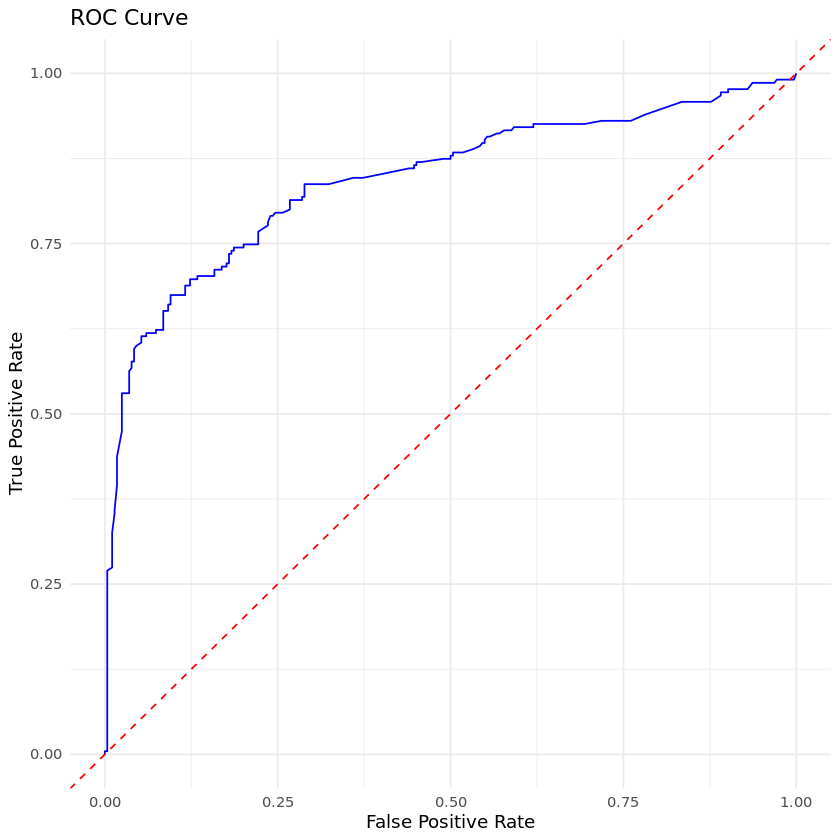

In [25]:
ROCRpred <- prediction(pred_train, train_data$Survived)

ROCRperf <- performance(ROCRpred, measure = "tpr", x.measure = "fpr")

roc_df <- data.frame(
  FPR = unlist(performance(ROCRpred, "fpr")@y.values),
  TPR = unlist(performance(ROCRpred, "tpr")@y.values)
)

ggplot(roc_df, aes(x = FPR, y = TPR)) +
  geom_line(color = "blue") +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +
  labs(title = "ROC Curve", x = "False Positive Rate", y = "True Positive Rate") +
  theme_minimal()

**Curve is between perfect classifier and random classifier. Closer to perfect one.**

In [26]:
performance(ROCRpred, measure = "auc")@y.values[[1]]

[1] 0.8441451

**Good discriminatory power within that dataset. It indicates that the model can effectively distinguish between the positive and negative classes (survived and not survived) within the training set.**

## Evaluate prediction performance

### Get predictions on test set and create a confusion matrix

In [27]:
pred_test <- predict(logistic_model, test_data[,!"Survived"], type = "response")
test_class <- ifelse(pred_test > 0.5, 1, 0)

In [28]:
table(actual=test_data[,`Survived`],
      pred=test_class) %>% confusionMatrix(positive = "1")

Confusion Matrix and Statistics

      pred
actual   0   1
     0 113  27
     1  24  51
                                         
               Accuracy : 0.7628         
                 95% CI : (0.7002, 0.818)
    No Information Rate : 0.6372         
    P-Value [Acc > NIR] : 5.371e-05      
                                         
                  Kappa : 0.4827         
                                         
 Mcnemar's Test P-Value : 0.7794         
                                         
            Sensitivity : 0.6538         
            Specificity : 0.8248         
         Pos Pred Value : 0.6800         
         Neg Pred Value : 0.8071         
             Prevalence : 0.3628         
         Detection Rate : 0.2372         
   Detection Prevalence : 0.3488         
      Balanced Accuracy : 0.7393         
                                         
       'Positive' Class : 1              
                                         

- TP: 51
- TN: 113
- FP: 27
- FN: 24

- Accuracy: 0.76 of all cases are correctly classified
- Sensitivity: 0.65 of the fitted positive cases are actually positive
- Specificity: 0.82 of the fitted negative cases are actually negative
- Kappa: 0.483, moderate aggreement

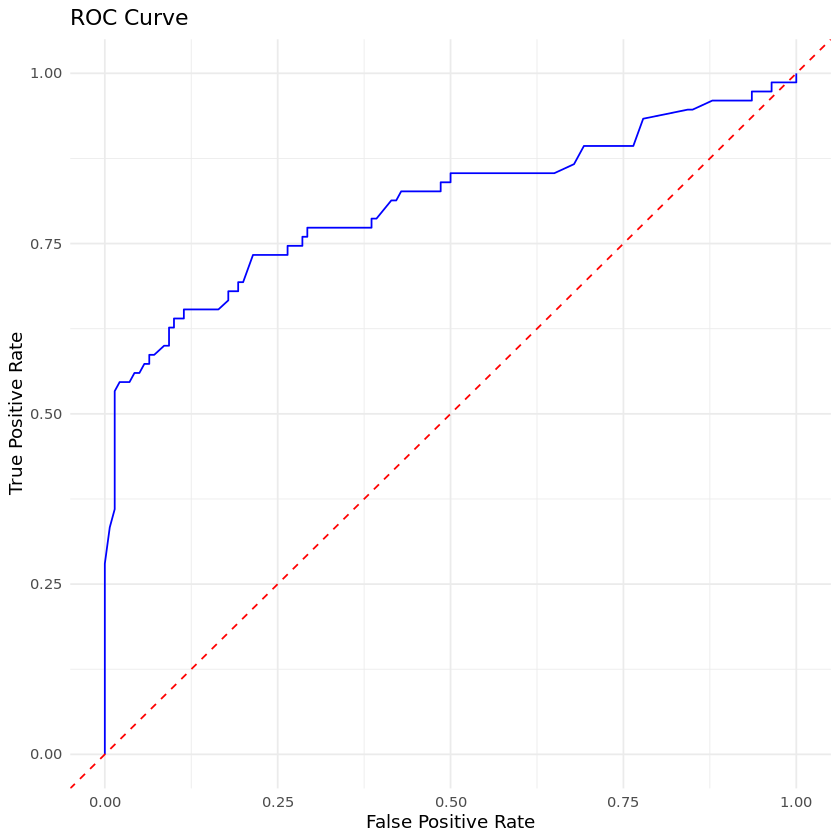

In [29]:
ROCRpred <- prediction(pred_test, test_data$Survived)

ROCRperf <- performance(ROCRpred, measure = "tpr", x.measure = "fpr")

roc_df <- data.frame(
  FPR = unlist(performance(ROCRpred, "fpr")@y.values),
  TPR = unlist(performance(ROCRpred, "tpr")@y.values)
)

ggplot(roc_df, aes(x = FPR, y = TPR)) +
  geom_line(color = "blue") +
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +
  labs(title = "ROC Curve", x = "False Positive Rate", y = "True Positive Rate") +
  theme_minimal()

**Curve is between perfect classifier and random classifier. Closer to perfect one.**

In [30]:
performance(ROCRpred, measure = "auc")@y.values[[1]]

[1] 0.8078571

**Logistic regression model generalizes reasonably well to new, unseen data. It indicates that the model maintains good discriminatory power when applied to data it hasn't seen during training.**